In [2271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rest = 'data/calibrated_magn_rest.csv'
calib_magn = 'data/calibrated_magn_trzy_obroty.csv'
out_path = 'data/calib_data_trzy_obroty.csv'
calc_path = 'data/collected_data_trzy_obroty.csv'

In [2272]:
def normalize_array(x):
    return x / np.linalg.norm(x)

def get_rotation_matrix(q):
    q1 = q[0][0]
    q2 = q[1][0]
    q3 = q[2][0]
    q4 = q[3][0]

    c11 = q1 ** 2 + q2 ** 2 - q3 ** 2 - q4 ** 2
    c12 = 2 * (q2 * q3 - q1 * q4)
    c13 = 2 * (q2 * q4 + q1 * q3)

    c21 = 2 * (q2 * q3 + q1 * q4)
    c22 = q1 ** 2 - q2 ** 2 + q3 ** 2 - q4 ** 2
    c23 = 2 * (q3 * q4 - q1 * q2)

    c31 = 2 * (q2 * q4 - q1 * q3)
    c32 = 2 * (q3 * q4 + q1 * q2)
    c33 = q1 ** 2 - q2 ** 2 - q3 ** 2 + q4 ** 2

    return np.array([
        [c11, c12, c13],
        [c21, c22, c23],
        [c31, c32, c33]
    ])


def get_euler_angles(q):
    rotation_matrix = get_rotation_matrix(q)
    c31 = rotation_matrix[2, 0]
    beta = -c31

    threshold = 1 - 0.0000000001
    sign = -1 if beta < -threshold else 1

    if beta < -threshold or beta > threshold:
        c12 = rotation_matrix[0, 1]
        c13 = rotation_matrix[0, 2]

        yaw = 0
        pitch = sign * np.pi / 2

        
        roll = np.arctan2(sign * c12, sign * c13)
    else:
 
        c21 = rotation_matrix[1, 0]
        c11 = rotation_matrix[0, 0]
        c31 = rotation_matrix[2, 0]
        c32 = rotation_matrix[2, 1]
        c33 =rotation_matrix[2, 2]

        yaw = np.arctan2(c21, c11)
        pitch = np.arcsin(-c31)
        roll = np.arctan2(c32, c33)

    yaw = yaw / np.pi * 180
    pitch = pitch / np.pi * 180
    roll = roll / np.pi * 180

    return roll, pitch, yaw

In [2273]:
class Kalman:
    def __init__(self, dt, gravity, mag_norm, G_0, acc_noise, gyro_noise, mag_noise):
        self.q = np.array([[1, 0, 0, 0]]).T # kwaternion
        self.P = 0.01 * np.eye(4) # macierz P

        # średni czas próbkowania
        self.dt = dt
        # znormalizowany wektor grawitacji z ~9.93 na osi Z acc
        self.g_n = gravity
        # znormalizowane pole magn
        self.m_n = mag_norm
        # norma grawitacji we wszystkich osiach
        self.G_0 = G_0

        # szumy
        self.acc_noise = acc_noise
        self.gyro_noise = gyro_noise
        self.mag_noise = mag_noise

    def propagate(self, gyro_k):

        (g1, g2, g3) = gyro_k
        Omega = np.array([
            [0, -g1, -g2, -g3],
            [g1, 0, g3, -g2],
            [g2, -g3, 0, g1],
            [g3, g2, -g1, 0]
        ])

        F_t = np.eye(4) + 0.5 * self.dt * Omega

        q1, q2, q3, q4 = self.q.T[0]
        W_t = 0.5 * np.array([
            [-q2, -q3, -q4],
            [ q1, -q4,  q3],
            [ q4,  q1, -q2],
            [-q3,  q2,  q1]
        ])
        Q = (self.gyro_noise * self.dt)**2 * W_t @ W_t.T
        
        self.q = F_t @ self.q
        self.q = normalize_array(self.q)
        self.P = F_t @ self.P @ F_t.T + Q


    def correct(self, acc_k, mag_k):
        err_acc = (self.acc_noise / np.linalg.norm(acc_k))**2
        err_mag = (self.mag_noise / np.linalg.norm(mag_k))**2

        R = np.diag(3 * [err_acc] + 3 * [err_mag])

        predicted_acc = normalize_array(get_rotation_matrix(self.q) @ self.g_n)
        predicted_mag = normalize_array(get_rotation_matrix(self.q) @ self.m_n)

        innovation = np.vstack((normalize_array(acc_k[:, np.newaxis]), 
                                normalize_array(mag_k[:, np.newaxis] ))) - np.vstack((predicted_acc, 
                                                                                      predicted_mag))

        H = np.vstack((
                        self.get_jacobian(self.g_n),
                        self.get_jacobian(self.m_n)
                        ))

        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S)

        self.q = self.q + K @ innovation
        self.q = normalize_array(self.q)

        self.P = self.P - K @ H @ self.P
        
    def get_jacobian(self, params):
        (x, y, z) = params.T[0]
        (qw, qx, qy, qz) = self.q.T[0]

        e00 = x*qw + y*qz - z*qy
        e01 = qx*x + qy*y + qz*z
        e02 = -qy*x + qx*y + qw*z
        e03 = -qz*x - qw*y + qx*z
        e10 = qz*x + qw*y - qx*z
        e11 = qy*x - qx*y - qw*z
        e12 = qx*x + qy*y + qz*z
        e13 = qw*x - qz*y + qy*z
        e20 = -qy*x + qx*y +qw*z
        e21 = qz*x + qw*y - qx*z
        e22 = -qw*x + qz*y - qy*z
        e23 = qx*x + qy*y + qz*z

        return 2 * np.array([
            [e00, e01, e02, e03],
            [e10, e11, e12, e13],
            [e20, e21, e22, e23]
        ])

# Preprocessing

In [2274]:
# wczytanie danych
data = pd.read_csv(calib_magn)
resting = pd.read_csv(rest)
resting

,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ
0,7050.793,-0.013,-0.017,1.019,0.323,-0.021,0.183,-6.667798,-9.260422,46.473826
1,7094.484,-0.013,-0.017,1.019,0.323,-0.021,0.183,-7.626415,-9.108090,44.616449
2,7131.618,-0.014,-0.016,1.018,0.328,-0.004,0.183,-7.626415,-9.108090,44.616449
3,7193.761,-0.014,-0.016,1.018,0.328,-0.004,0.183,-7.146859,-9.556084,45.545138
4,7210.394,-0.013,-0.016,1.019,0.315,-0.004,0.183,-7.146859,-9.556084,45.545138
...,...,...,...,...,...,...,...,...,...,...
414,25282.541,-0.013,-0.017,1.019,0.319,-0.021,0.183,-6.349065,-8.368036,46.473826
415,25291.384,-0.013,-0.017,1.019,0.319,-0.021,0.183,-7.306897,-8.665198,46.319044
416,25361.312,-0.014,-0.016,1.019,0.310,-0.026,0.183,-7.306897,-8.665198,46.319044
417,25390.660,-0.014,-0.016,1.019,0.310,-0.026,0.183,-7.625420,-10.003177,46.009482


In [2275]:
# średnia czasu między próbkami
dt = np.mean(np.diff(data['time'])) / 1000
# ilość próbek w 1 sekundzie
init_time = int(1 / dt)

In [2276]:
# BIAS
headers = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']
bias_data = data[headers]
data_init = resting[headers]
prepared_data = bias_data - data_init.mean()
prepared_data['accZ'] += 1.0
prepared_data = pd.concat([data.time, prepared_data, data[['magX', 'magY', 'magZ']]], axis=1)


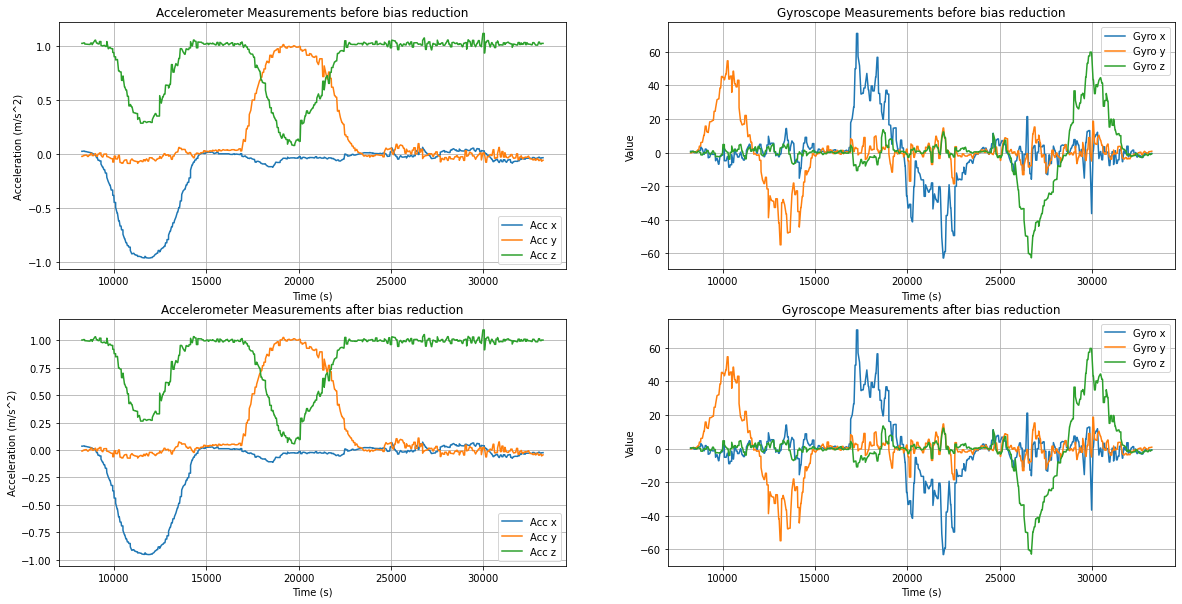

In [2277]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.grid()
plt.plot(data.time, data.accX, label='Acc x')
plt.plot(data.time, data.accY, label='Acc y')
plt.plot(data.time, data.accZ, label='Acc z')
plt.title('Accelerometer Measurements before bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 2, 3)
plt.grid()
plt.plot(prepared_data.time, prepared_data.accX, label='Acc x')
plt.plot(prepared_data.time, prepared_data.accY, label='Acc y')
plt.plot(prepared_data.time, prepared_data.accZ, label='Acc z')
plt.title('Accelerometer Measurements after bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(data.time, data.gyroX, label='Gyro x')
plt.plot(data.time, data.gyroY, label='Gyro y')
plt.plot(data.time, data.gyroZ, label='Gyro z')
plt.title('Gyroscope Measurements before bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 2, 4)
plt.grid()
plt.plot(prepared_data.time, prepared_data.gyroX, label='Gyro x')
plt.plot(prepared_data.time, prepared_data.gyroY, label='Gyro y')
plt.plot(prepared_data.time, prepared_data.gyroZ, label='Gyro z')
plt.title('Gyroscope Measurements after bias reduction')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

In [2278]:
# MAG
mag = prepared_data[['magX', 'magY', 'magZ']].to_numpy()

# ACC
G = 9.81
acc = prepared_data[['accX', 'accY', 'accZ']].to_numpy() * G

# GYRO - zamiana na radiany
gyro = (prepared_data[['gyroX', 'gyroY', 'gyroZ']].to_numpy()) / 180 * np.pi


# MAG FIELD
mag_mean = mag.mean(axis=0)
mag_norm = mag_mean / np.linalg.norm(mag_mean)
mag_norm = mag_norm[:, np.newaxis] 

# VAR
mag_var = mag.var(axis=0)
acc_var = acc.var(axis=0)
gyro_var = gyro.var(axis=0)

# NOISE
mag_noise = 10 * np.linalg.norm(mag_var)
acc_noise = 10 * np.linalg.norm(acc_var)
gyro_noise = 10 * np.linalg.norm(gyro_var)

# 
gravity = acc.mean(axis=0)
gravity =  gravity[:, np.newaxis]
gravity_0 = np.linalg.norm(gravity)

prepared_data['time'] = data['time']
prepared_data.to_csv(out_path)

# Kalman

In [2279]:
kf = Kalman(dt, gravity, mag_norm, gravity_0, acc_noise, gyro_noise, mag_noise)

In [2280]:
accX_data = []
accY_data = []
accZ_data = []
gyroX_data = []
gyroY_data = []
gyroZ_data = []
magX_data = []
magY_data = []
magZ_data = []
roll_data = []
pitch_data = []
yaw_data = []

current_frame = 0
number_of_samples = prepared_data.shape[0]

while current_frame < number_of_samples:

    accX_data.append(acc[0][0])
    accY_data.append(acc[1][0])
    accZ_data.append(acc[2][0])
    gyroX_data.append(gyro[0][0])
    gyroY_data.append(gyro[1][0])
    gyroZ_data.append(gyro[2][0])
    magX_data.append(mag[0][0])
    magY_data.append(mag[1][0])
    magZ_data.append(mag[2][0])

    (acc_temp, gyro_temp, mag_temp) = acc[current_frame], gyro[current_frame], normalize_array(mag[current_frame])

    kf.propagate(gyro_temp)
    kf.correct(acc_temp, mag_temp)

    (roll, pitch, yaw) = get_euler_angles(kf.q)
    roll_data.append(roll)
    pitch_data.append(pitch)
    yaw_data.append(yaw)

    current_frame += 1

df = pd.DataFrame()
df['time'] = prepared_data['time']
df['accX'] = accX_data
df['accY'] = accY_data
df['accZ'] = accZ_data
df['gyroX'] = gyroX_data
df['gyroY'] = gyroY_data
df['gyroZ'] = gyroZ_data
df['magX'] = magX_data
df['magY'] = magY_data
df['magZ'] = magZ_data
df['roll'] = roll_data
df['pitch'] = pitch_data
df['yaw'] = yaw_data
df.to_csv(calc_path)
df

,time,accX,accY,accZ,gyroX,gyroY,gyroZ,magX,magY,magZ,roll,pitch,yaw
0,8267.488,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.037327,0.010010,0.006436
1,8313.232,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.075724,0.021002,0.012843
2,8346.271,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.113094,0.054675,0.034893
3,8412.517,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.151444,0.089239,0.056932
4,8425.046,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,0.168357,0.139901,0.065738
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,33036.279,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,-1.774714,-0.306612,-3.126007
571,33069.310,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,-1.758644,-0.253101,-3.164887
572,33135.567,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,-1.742589,-0.199923,-3.204373
573,33148.095,0.345223,0.345223,0.364843,0.00804,0.00804,0.00743,21.939253,22.524235,22.524235,-1.745140,-0.144002,-3.254655


# Visualization

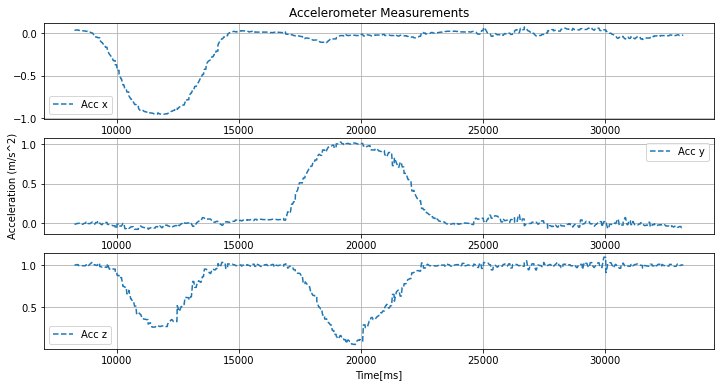

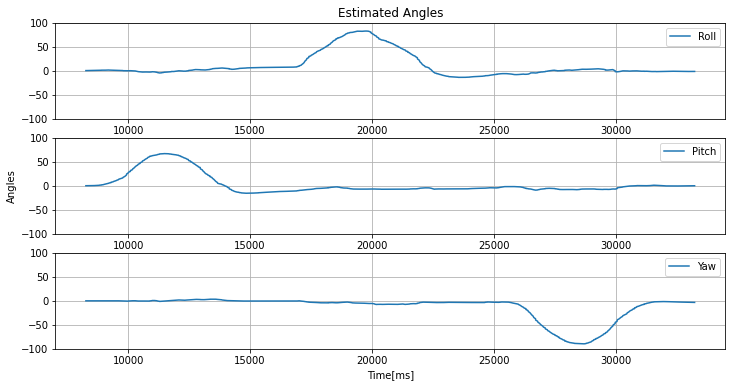

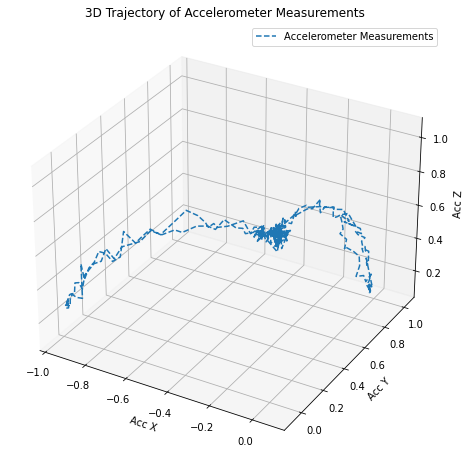

In [2281]:
time = prepared_data['time']
acc_measurements = prepared_data[['accX', 'accY', 'accZ']].values
gyro_measurements = prepared_data[['gyroX', 'gyroY', 'gyroZ']].values
mag_measurements = prepared_data[['magX', 'magY', 'magZ']].values


plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.title('Accelerometer Measurements')
plt.plot(time, acc_measurements[:, 0], label='Acc x', linestyle='--')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, acc_measurements[:, 1], label='Acc y', linestyle='--')
plt.grid()
plt.legend()
plt.ylabel('Acceleration (m/s^2)')

plt.subplot(3, 1, 3)
plt.plot(time, acc_measurements[:, 2], label='Acc z', linestyle='--')
plt.grid()
plt.legend()
plt.xlabel('Time[ms]')


plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.title('Estimated Angles')
plt.plot(time, df['roll'], label='Roll')
plt.grid()
plt.ylim(-100, 100)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, df['pitch'], label='Pitch')
plt.grid()
plt.ylim(-100, 100)
plt.legend()
plt.ylabel('Angles')

plt.subplot(3, 1, 3)
plt.plot(time, df['yaw'], label='Yaw')
plt.grid()
plt.ylim(-100, 100)
plt.legend()
plt.xlabel('Time[ms]')


# Plot the 3D trajectory of accelerometer measurements
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(acc_measurements[:, 0], acc_measurements[:, 1], acc_measurements[:, 2], label='Accelerometer Measurements', linestyle='--')
ax.set_xlabel('Acc X')
ax.set_ylabel('Acc Y')
ax.set_zlabel('Acc Z')
ax.set_title('3D Trajectory of Accelerometer Measurements')
ax.legend()

plt.show()